# Named Entity Recognition using RNN

## Import Required Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from matplotlib import pyplot as plt

from nltk.corpus import brown
from nltk.corpus import treebank
import nltk
import seaborn as sns

from gensim.models import KeyedVectors

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.


## Dataset

In [2]:
file1 = open("eng.train", "r")
X = [] # contains the words
Y = [] # contains corresponding tags
x = []
y = []
for i in file1:
  s = i.split(" ")
  if s[0]!='.' and len(s)==4:
    x.append(s[0])
    y.append(s[3][:-1])
  else:
    X.append(x)
    Y.append(y)
    x = []
    y = []
#print(X)
#print(Y)

In [3]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

In [4]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))


Total number of tagged sentences: 22360
Vocabulary size: 21009
Total number of tags: 8


## Encoding

In [7]:
# encode X

word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X)  # use the tokeniser to encode input sequence

In [8]:
# encode Y

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [10]:
# make sure that each sequence of input and output is same length

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


In [11]:
# check length of longest sentence
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 113


## Padding

In [12]:
MAX_SEQ_LENGTH = 100  # sequences greater than 100 in length will be truncated

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")


In [14]:
# assign padded sequences to X and Y
X, Y = X_padded, Y_padded

## Word2Vec Model

In [16]:
# word2vec

path = './GoogleNews-vectors-negative300.bin'


# load word2vec using the following function present in the gensim library
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)


In [17]:
#assign word vectors from word2vec model

EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [18]:
# check embedding dimension
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (21010, 300)


In [19]:
# let's look at an embedding of a word
embedding_weights[word_tokenizer.word_index['economy']]


array([ 0.18847656, -0.0703125 , -0.16113281,  0.03857422, -0.04956055,
       -0.23046875, -0.15722656, -0.16992188,  0.17089844, -0.01208496,
       -0.16015625, -0.02770996,  0.05932617,  0.00491333, -0.13769531,
        0.39257812,  0.06201172,  0.30859375,  0.12890625, -0.07373047,
       -0.07128906,  0.26953125,  0.22167969,  0.04150391, -0.01361084,
       -0.1953125 ,  0.06884766, -0.04541016,  0.36328125, -0.05761719,
       -0.16308594, -0.45507812, -0.16699219, -0.09179688,  0.15234375,
       -0.08984375,  0.33789062,  0.01574707, -0.08789062,  0.3984375 ,
       -0.03112793, -0.15234375,  0.30859375,  0.23242188,  0.08984375,
        0.0050354 ,  0.25585938,  0.24316406, -0.27734375,  0.171875  ,
        0.23144531,  0.23242188, -0.12597656,  0.03613281,  0.2890625 ,
        0.00469971, -0.02441406,  0.31835938,  0.19726562, -0.14257812,
       -0.01867676,  0.01495361, -0.37695312, -0.06298828,  0.09814453,
       -0.04736328, -0.02087402,  0.01757812,  0.06982422,  0.01

In [20]:
# use Keras' to_categorical function to one-hot encode Y
Y = to_categorical(Y)

In [21]:
# print Y of the first output sequqnce
print(Y.shape)

(22360, 100, 9)


## Splitting Dataset

In [22]:
# split entire data into training and testing sets
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=4)

In [23]:
# split training data into training and validation sets
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)


In [24]:
# total number of tags
NUM_CLASSES = Y.shape[2]

## RNN Model

In [29]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compiling the Model

In [30]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

## Summary of the Model

In [31]:
# check summary of the model
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          6303000   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 100, 64)           23360     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 100, 9)            585       
Total params: 6,326,945
Trainable params: 6,326,945
Non-trainable params: 0
_________________________________________________________________


## Training the Model

In [32]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Train on 16155 samples, validate on 2851 samples
Epoch 1/10
16155/16155 [==============================] - 27s 2ms/step - loss: 0.2633 - acc: 0.9454 - val_loss: 0.0701 - val_acc: 0.9827
Epoch 2/10
16155/16155 [==============================] - 26s 2ms/step - loss: 0.0482 - acc: 0.9867 - val_loss: 0.0370 - val_acc: 0.9896
Epoch 3/10
16155/16155 [==============================] - 26s 2ms/step - loss: 0.0257 - acc: 0.9934 - val_loss: 0.0249 - val_acc: 0.9935
Epoch 4/10
16155/16155 [==============================] - 26s 2ms/step - loss: 0.0159 - acc: 0.9965 - val_loss: 0.0194 - val_acc: 0.9949
Epoch 5/10
16155/16155 [==============================] - 26s 2ms/step - loss: 0.0108 - acc: 0.9978 - val_loss: 0.0166 - val_acc: 0.9955
Epoch 6/10
16155/16155 [==============================] - 26s 2ms/step - loss: 0.0079 - acc: 0.9983 - val_loss: 0.0151 - val_acc: 0.9957
Epoch 7/10
16155/16155 [==============================] - 26s 2ms/step - loss: 0.0061 - acc: 0.9986 - val_loss: 0.0145 - val_acc:

## Plot

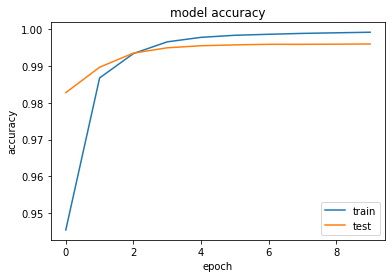

In [34]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()


## Saving the Model

In [35]:
rnn_model.save('ner-rnn.h5')